# Jira Comments Analysis – Sentiment & Themes

This notebook loads Jira comments from a CSV file and walks through:

1. **Loading & inspecting the data**
2. **Cleaning / preprocessing the comment text**
3. **Running sentiment analysis with a HuggingFace model**
4. **Clustering comments into themes (reasons for delay) using TF‑IDF + KMeans**
5. **Summarizing the top reasons issues weren’t completed**

> 🔧 Before you start: update the `csv_path` variable in **Cell 2** so it points to your `JiraComments_FromJql.csv` file on your machine (e.g. `C:\\Users\\Andy\\Desktop\\JiraComments_FromJql.csv`).

In [1]:
# Cell 1 – Imports and (optional) installs
# Run this cell first.

# If you don't have these installed yet, uncomment the pip commands below
# (remove the leading '#') and run once.

# !pip install pandas matplotlib scikit-learn transformers sentencepiece accelerate -q

import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

plt.style.use("ggplot")

In [7]:
# Cell 2 – Load CSV (update csv_path for your machine)

# 👉 Change this to the actual path of your CSV file.
# Example:
# csv_path = r"C:\Users\Andy\Desktop\JiraComments_FromJql.csv"

csv_path = r"C:\Users\Andy\Desktop\Text Analysis\JiraComments_FromJql.csv"  # <-- update this line

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at: {csv_path}\nPlease update csv_path to the correct location.")

df = pd.read_csv(csv_path)

print("Rows:", len(df))
print("Columns:", list(df.columns))
df.head()

Rows: 241
Columns: ['IssueKey', 'CommentId', 'Author', 'AuthorEmail', 'Created', 'Updated', 'Body']


,IssueKey,CommentId,Author,AuthorEmail,Created,Updated,Body
0,SWIFT-7544,55859,Molly Andrasik,molly.andrasik@rochesterregional.org,2025-10-28T11:26:52.037-0400,2025-10-28T11:26:52.037-0400,This was not ready for PRD by 10/27. Dr. Mulli...
1,SWIFT-7544,56452,Molly Andrasik,molly.andrasik@rochesterregional.org,2025-11-04T12:32:55.637-0500,2025-11-04T12:32:55.637-0500,[~SMULLIN] and [~T324172] - We were targeting ...
2,SWIFT-7544,56508,"Mullin, Suzanne",Suzanne.Mullin@rochesterregional.org,2025-11-04T13:19:01.640-0500,2025-11-04T13:19:01.640-0500,Yes. Working on it now\r\n\r\n
3,SWIFT-7544,56584,Molly Andrasik,molly.andrasik@rochesterregional.org,2025-11-05T11:50:14.713-0500,2025-11-05T11:50:14.713-0500,CRQ7023685 planned for Maintenance release on ...
4,SWIFT-7543,55787,Molly Andrasik,molly.andrasik@rochesterregional.org,2025-10-28T10:22:16.687-0400,2025-10-28T10:22:16.687-0400,[~SMULLIN] and [~LYOGIS] was this completed la...


## Basic cleaning & selection

We keep the most relevant columns:

- **IssueKey** – which Jira issue the comment belongs to  
- **Author** (if present) – who wrote the comment  
- **Created / Updated** – timestamps  
- **Body** – the actual comment text

We’ll create a cleaned‑up `text_clean` column for analysis.

In [9]:
# Cell 3 – Select relevant columns and clean text

# Try common column names; adjust if your CSV uses different ones
possible_issue_cols = ["IssueKey", "issueKey", "Key", "key"]
possible_body_cols = ["Body", "body", "Comment", "comment"]

issue_col = next((c for c in possible_issue_cols if c in df.columns), None)
body_col  = next((c for c in possible_body_cols  if c in df.columns), None)

if issue_col is None or body_col is None:
    raise ValueError(f"Could not find issue or body column.\n"
                     f"Available columns: {list(df.columns)}\n"
                     f"Expected something like {possible_issue_cols} and {possible_body_cols}")

print(f"Using issue column: {issue_col}")
print(f"Using body column : {body_col}")

# Keep a working copy
data = df[[issue_col, body_col]].copy()
data.rename(columns={issue_col: "IssueKey", body_col: "Body"}, inplace=True)

# Drop empty comments
data["Body"] = data["Body"].astype(str).str.strip()
data = data[data["Body"].str.len() > 0].reset_index(drop=True)

print("After dropping empty comments:", len(data))

# Simple text cleaning function
import re

def clean_text(text: str) -> str:
    text = str(text)
    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    # Remove Jira-like markup (basic)
    text = re.sub(r"\[~?\w+\]", " ", text)  # mentions
    # Remove non-alphanumeric except basic punctuation
    text = re.sub(r"[^a-zA-Z0-9\s,.!?'-]", " ", text)
    # Collapse whitespace
    text = re.sub(r"\s+", " ", text)
    return text.strip().lower()

data["text_clean"] = data["Body"].apply(clean_text)

data.head()

Using issue column: IssueKey
Using body column : Body
After dropping empty comments: 241


,IssueKey,Body,text_clean
0,SWIFT-7544,This was not ready for PRD by 10/27. Dr. Mulli...,this was not ready for prd by 10 27. dr. mulli...
1,SWIFT-7544,[~SMULLIN] and [~T324172] - We were targeting ...,and - we were targeting this for 11 6. is that...
2,SWIFT-7544,Yes. Working on it now,yes. working on it now
3,SWIFT-7544,CRQ7023685 planned for Maintenance release on ...,crq7023685 planned for maintenance release on ...
4,SWIFT-7543,[~SMULLIN] and [~LYOGIS] was this completed la...,and was this completed last week? has it been ...


## Sentiment analysis with HuggingFace

We’ll use a pretrained sentiment model from HuggingFace to label each comment as **positive** or **negative** (and a score).  
Feel free to change the model name if you prefer another sentiment model.

In [11]:
# Cell 4 – Setup HuggingFace sentiment pipeline

# You can change this to another English sentiment model if you like
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

sentiment_model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_tokenizer = AutoTokenizer.from_pretrained(model_name)

sentiment_pipe = pipeline(
    "sentiment-analysis",
    model=sentiment_model,
    tokenizer=sentiment_tokenizer,
    device=-1  # use CPU; set to 0 to use GPU if available
)

sentiment_pipe("This is a quick test to see if the model works.")

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

C:\Users\Andy\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Andy\.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'NEGATIVE', 'score': 0.9964632391929626}]

In [13]:
# Cell 5 – Run sentiment on all comments (batched)

texts = data["text_clean"].tolist()
results = []

batch_size = 32

for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    batch_results = sentiment_pipe(batch, truncation=True)
    results.extend(batch_results)
    print(f"Processed {min(i+batch_size, len(texts))}/{len(texts)} comments", end="\r")

print("\nDone.")

data["sentiment_label"] = [r["label"] for r in results]
data["sentiment_score"] = [r["score"] for r in results]

data.head()

Processed 241/241 comments
Done.


,IssueKey,Body,text_clean,sentiment_label,sentiment_score
0,SWIFT-7544,This was not ready for PRD by 10/27. Dr. Mulli...,this was not ready for prd by 10 27. dr. mulli...,NEGATIVE,0.999208
1,SWIFT-7544,[~SMULLIN] and [~T324172] - We were targeting ...,and - we were targeting this for 11 6. is that...,NEGATIVE,0.998937
2,SWIFT-7544,Yes. Working on it now,yes. working on it now,POSITIVE,0.999251
3,SWIFT-7544,CRQ7023685 planned for Maintenance release on ...,crq7023685 planned for maintenance release on ...,NEGATIVE,0.994122
4,SWIFT-7543,[~SMULLIN] and [~LYOGIS] was this completed la...,and was this completed last week? has it been ...,NEGATIVE,0.999292


sentiment_label
NEGATIVE    192
POSITIVE     49
Name: count, dtype: int64


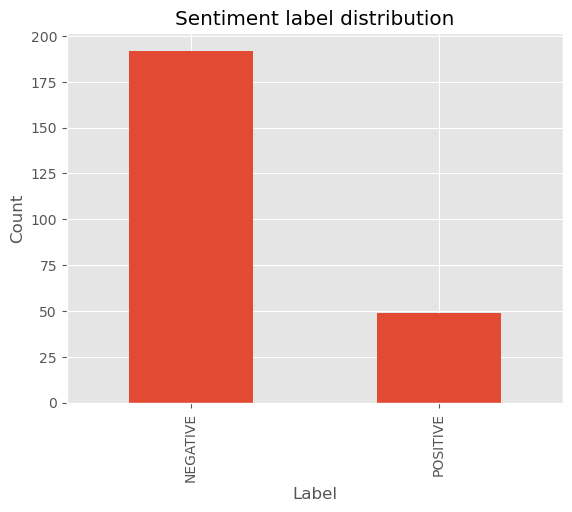

,count,mean,std,min,25%,50%,75%,max
sentiment_label,,,,,,,,
NEGATIVE,192.0,0.952033,0.105345,0.500739,0.974561,0.994295,0.998799,0.999783
POSITIVE,49.0,0.944625,0.088154,0.626347,0.921758,0.988804,0.995820,0.999847


In [15]:
# Cell 6 – Sentiment summary

print(data["sentiment_label"].value_counts())

# Plot distribution
data["sentiment_label"].value_counts().plot(kind="bar")
plt.title("Sentiment label distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Average score by label
data.groupby("sentiment_label")["sentiment_score"].describe()

## Thematic analysis (reasons / topics)

We’ll use a simple unsupervised approach:

1. Convert comments into TF‑IDF vectors.  
2. Cluster them using KMeans.  
3. Inspect the **top terms per cluster** and some **example comments** to interpret themes.

You can adjust the number of clusters (`n_clusters`) depending on how fine‑grained you want the themes to be.

In [17]:
# Cell 7 – TF-IDF vectorization

# You can tweak max_features or stop_words if needed
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words="english"
)

X = vectorizer.fit_transform(data["text_clean"])
X.shape

(241, 5000)

In [23]:
import threadpoolctl

class _NoOpThreadpoolLimit:
    def __init__(self, *args, **kwargs):
        pass
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        pass

# Monkey-patch threadpoolctl so scikit-learn's KMeans doesn't try
# to introspect BLAS libraries (which is what's crashing on Windows).
threadpoolctl.threadpool_limits = _NoOpThreadpoolLimit

print("Patched threadpoolctl.threadpool_limits – KMeans should work now.")


Patched threadpoolctl.threadpool_limits – KMeans should work now.


In [25]:
# Cell 8 – KMeans clustering into themes

n_clusters = 6  # adjust this number as needed

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42,
    n_init=10
)

cluster_labels = kmeans.fit_predict(X)
data["cluster"] = cluster_labels

data["cluster"].value_counts().sort_index()

cluster
0    117
1     25
2     28
3     27
4     33
5     11
Name: count, dtype: int64

In [27]:
# Cell 9 – Inspect top terms per cluster

def print_top_terms_per_cluster(kmeans_model, vectorizer, n_terms=15):
    terms = np.array(vectorizer.get_feature_names_out())
    order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
    for i in range(kmeans_model.n_clusters):
        top_terms = terms[order_centroids[i, :n_terms]]
        print(f"\nCluster {i} – top terms:")
        print(", ".join(top_terms))

print_top_terms_per_cluster(kmeans, vectorizer, n_terms=15)


Cluster 0 – top terms:
release, design, november, november release, update, need, moving, swift, build, operations, prd, completed, fyi, complete, meeting

Cluster 1 – top terms:
updated, epic, mtg, uploaded, design, design epic, date, notes, just, msow, smart, afternoon, update, care, needs

Cluster 2 – top terms:
10 27, 27, 10, release, prd, 27 release, validation, crq, november release, waiting, switchboard, live, track, november, dev

Cluster 3 – top terms:
order, orders, team, thanks, set, order set, orders team, work, testing, lab, anticipate, new, ed, need, otx

Cluster 4 – top terms:
scheduled, design, 10, 30, meeting, 10 30, 11, scheduled 11, design session, session scheduled, scheduled 10, session, meeting scheduled, checking design, started

Cluster 5 – top terms:
design complete, complete, design, complete swift, swift, mark, development, meeting 10, point, complete point, following, marked, development november, idea, 22 design


In [29]:
# Cell 10 – Example comments per cluster

for c in range(n_clusters):
    print(f"\n==================== Cluster {c} ====================")
    cluster_subset = data[data["cluster"] == c].head(5)  # show up to 5 examples
    for _, row in cluster_subset.iterrows():
        print(f"[{row['IssueKey']}] ({row['sentiment_label']}, {row['sentiment_score']:.2f})")
        print(row["Body"][:500])
        print("----")


==================== Cluster 0 ====================
[SWIFT-7544] (NEGATIVE, 1.00)
[~SMULLIN] and [~T324172] - We were targeting this for 11/6. Is that still the plan?
----
[SWIFT-7544] (POSITIVE, 1.00)
Yes.  Working on it now
----
[SWIFT-7544] (NEGATIVE, 0.99)
CRQ7023685 planned for Maintenance release on 11/6.
----
[SWIFT-7543] (NEGATIVE, 1.00)
[~SMULLIN] and [~LYOGIS] was this completed last week? Has it been moved to PRD?
----
[SWIFT-7492] (NEGATIVE, 0.67)
mg/kg unit added to ERX 200145
----

==================== Cluster 1 ====================
[SWIFT-7492] (POSITIVE, 1.00)
Already updated my build to reflect the willow changes and tested with [~K341492], its good to go
----
[SWIFT-7393] (NEGATIVE, 0.91)
[~m328246], this is not yet updated. I'd be happy to help if you could guide me on where to update the date.
----
[SWIFT-7393] (NEGATIVE, 1.00)
[~V313484] I had updated the Fix Version (Release), but forgot to update the end date on the EPIC and IDEA. that has been done now.

Is the

## Putting it together: top themes & blocker-style comments

At this point you can:

- Manually label each cluster with a **theme name** (e.g., “Waiting on other team”, “Testing issues”, “Requirements unclear”).  
- Filter for **negative** comments within each cluster to see which themes are associated with delays or frustration.  
- Export the enriched dataset back to CSV for reporting or dashboards.

In [31]:
# Cell 11 – Example: negative comments by cluster

neg = data[data["sentiment_label"] == "NEGATIVE"]

summary = neg.groupby("cluster").agg(
    n_comments=("Body", "count")
).reset_index().sort_values("n_comments", ascending=False)

summary

,cluster,n_comments
0,0,97
2,2,24
4,4,24
1,1,21
3,3,19
5,5,7


In [ ]:
# Cell 12 – Export enriched data (optional)

output_path = os.path.splitext(csv_path)[0] + "_enriched_with_sentiment_clusters.csv"
data.to_csv(output_path, index=False)
print(f"Saved enriched data to: {output_path}")